# IMDB Sentiments

## Introduction

This notebook follows the Text Classification guide from Google Machine Learning Guides.<br/>
This notebook contains all the code that the guide shows in the tutorial and not in its github repo. Hope this guide helps you as you follow the Text Classification guide.

Link to the Guide: https://developers.google.com/machine-learning/guides/text-classification/

In this notebook, we see how to perform sentiment analysis using IMDB Movie Reviews Dataset. We will classify reviews into `2` labels: _positive(`1`)_ and _negetive(`0`)_. And we will encode the data using tf-idf and feed into a Multi-layer Perceptron. We will use tensorflow, with Keras API.

## Loading the required modules

Let;s get started by loading all the required modules and defining all the constants and variables that we will be needing all throughout the notebook

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

path = 'data/'

## Load the Dataset

In this section, let's load the dataset and shuffle it so to make ready for analysis.

In [2]:
import os
path='C:/Users/Zaid Naeem/Documents/final Anaconda/data/aclImdb/'

#path = 'C:\Users\Zaid Naeem\Documents\final Anaconda\data\aclImdb'
positiveFiles = [x for x in os.listdir(path+"train/pos/") if x.endswith(".txt")]
negativeFiles = [x for x in os.listdir(path+"train/neg/") if x.endswith(".txt")]
testFiles = [x for x in os.listdir(path+"test/") if x.endswith(".txt")]

In [3]:
positiveReviews, negativeReviews, testReviews = [], [], []
for pfile in positiveFiles:
    with open(path+"train/pos/"+pfile, encoding="latin1") as f:
        positiveReviews.append(f.read())
for nfile in negativeFiles:
    with open(path+"train/neg/"+nfile, encoding="latin1") as f:
        negativeReviews.append(f.read())
for tfile in testFiles:
    with open(path+"test/"+tfile, encoding="latin1") as f:
        testReviews.append(f.read())

Now, lets load the dataset and perform some analysis on the dataset!

In [4]:
reviews = pd.concat([
    pd.DataFrame({"review":positiveReviews, "label":1, "file":positiveFiles}),
    pd.DataFrame({"review":negativeReviews, "label":0, "file":negativeFiles}),
    pd.DataFrame({"review":testReviews, "label":-1, "file":testFiles})
], ignore_index=True).sample(frac=1, random_state=1)
reviews.head()

review  label         file
21939  Gwyneth Paltrow is absolutely great in this mo...      0   7246_4.txt
24113  I own this movie. Not by choice, I do. I was r...      0   9202_1.txt
4633   Well I guess it supposedly not a classic becau...      1   2920_8.txt
17240  I am, as many are, a fan of Tony Scott films. ...      0   3016_1.txt
4894   I wish "that '70s show" would come back on tel...      1  3155_10.txt

Okay, that's 25K samples in each train and test sets! Now, from here on we will do analysis only on the train set (we want no snooping bias!)

Alright, now we have `2` classes as we divided them, one for positive `1` and one for negetive `0`. Let's just verify that!

And let's also verify the number of samples that are present in each class.

In [5]:
reviews.shape #to check columns and rows

(25002, 3)

In [6]:
import matplotlib

import seaborn as sns

%matplotlib inline

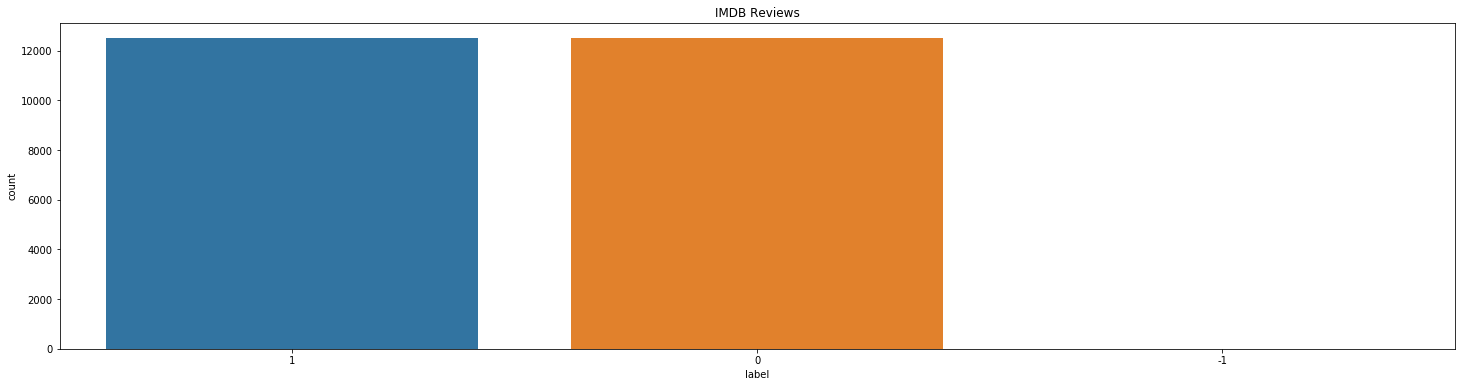

In [7]:
from matplotlib import pyplot
y = reviews["label"]
fig, ax = pyplot.subplots(figsize=(25,6))
ax.set_title("IMDB Reviews")
ax = sns.countplot(y,label="Count",ax=ax,order=reviews.label.value_counts().iloc[:15].index )     


In [8]:
data1=reviews.loc[reviews.label==1]
data0=reviews.loc[reviews.label==0]

In [9]:
f=pd.concat([data1, data0]) 


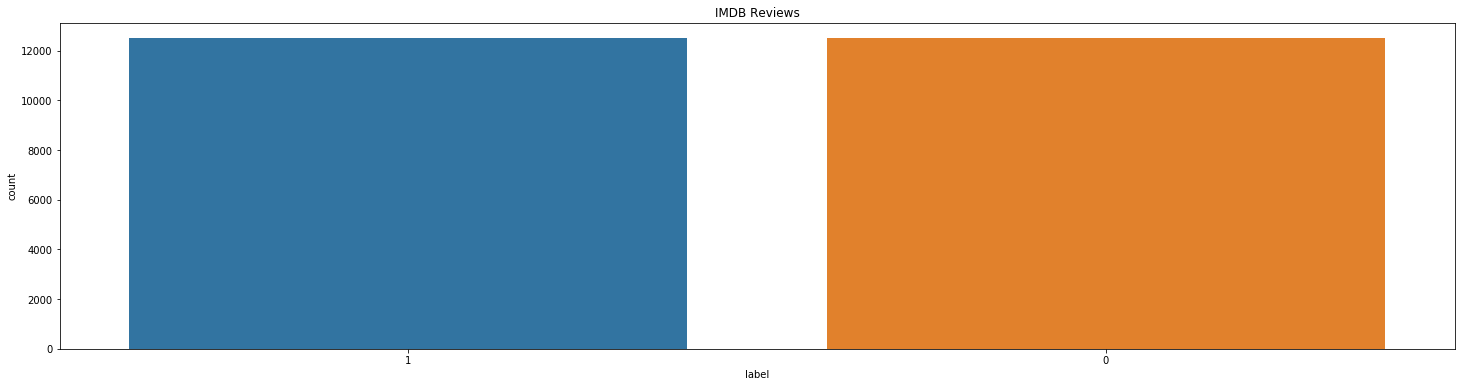

In [10]:
from matplotlib import pyplot
y = f["label"]
fig, ax = pyplot.subplots(figsize=(25,6))
ax.set_title("IMDB Reviews")
ax = sns.countplot(y,label="Count",ax=ax,order=f.label.value_counts().iloc[:15].index )   

In [11]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize 
from nltk.stem.lancaster import LancasterStemmer 
from nltk.stem import SnowballStemmer 
sb_stemmer = SnowballStemmer("english",) 
stop_words=set(stopwords.words('english'))
porter_stemmer = PorterStemmer()
fcorpus=[]
for i in range(0,len(f)):
    review = re.sub('[/(){}\[\]\|@!,;]', ' ',f['review'][i])
    tokens=nltk.word_tokenize(review)
    words=[tokens.lower() for tokens in tokens if tokens.isalpha()]
    word=[porter_stemmer.stem(wor) for wor in words]
    wor=[w for w in word if not w in stop_words]
    review=' '.join(wor)
    fcorpus.append(review)
fcorpus


['bromwel high cartoon comedi ran time program school life teacher year teach profess lead believ bromwel high satir much closer realiti teacher scrambl surviv financi insight student see right pathet teacher pomp petti whole situat remind school knew student saw episod student repeatedli tri burn school immedi recal high classic line inspector sack one teacher student welcom bromwel high expect mani adult age think bromwel high far fetch piti',
 'homeless houseless georg carlin state ha issu year never plan help street onc consid human everyth go school work vote matter peopl think homeless lost caus worri thing racism war iraq pressur kid succeed technolog elect inflat worri next end br br given bet live street month without luxuri onc home entertain set bathroom pictur wall comput everyth onc treasur see like homeless goddard bolt br br mel brook direct star bolt play rich man ha everyth world decid make bet sissi rival jefferi tambor see live street thirti day without luxuri bolt s

In [12]:
#Splitting dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(fcorpus, f.label, test_size=0.25)

In [13]:
X_train

['plot rocki act somewher south high school play cinematographi bad look like wa cut machet could decid thi wa intent hokey flick peopl behind actual thought make good film think death valley day meet mayberri rfd peopl run around modern town wear gun rig ha fair share stuff pictur good guy pull old farm hous park ford mustang right front hitch rail pictur clerk hotel watch obvious western hemispher movi sport japanes sound track english realli strang might improv watch partak littl peyot real curios modern parallel everi western movi think even modern version good heart girl twang soundtrack realli someon bring thi home saturday night movi session tell dvd player die',
 'well thi wa one film caught wa good enough record show next time like enjoy mani horror flick branch littl norm anoth glut gener sequel think may enjoy thi bad guy eventu turn person wa definit expect see would go way thi one like genr watch come hour half kill guess give',
 'fact posit comment dan real life imdb make

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_tf = vectorizer.fit_transform(X_train)
X_test_tf=vectorizer.transform(X_test)

In [10]:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA, TruncatedSVD
union = FeatureUnion([("pca", PCA(n_components=1000)),("svd", TruncatedSVD(n_components=1000))])
fcourp=union.fit_transform(X_train_tf.todense())  
fcourp

NameError: name 'X_train_tf' is not defined

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [16]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()
dtPre=dt.fit(X_train_tf, y_train).predict(X_test_tf)
accuracy_score(y_test,dtPre)


0.70512

In [40]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=100,max_depth=50)
rfc1=rfc.fit(X_train_tf, y_train).predict(X_test_tf)
print(accuracy_score(y_test,rfc1))
print(classification_report(y_test,rfc1))

0.84864
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3145
           1       0.84      0.86      0.85      3105

    accuracy                           0.85      6250
   macro avg       0.85      0.85      0.85      6250
weighted avg       0.85      0.85      0.85      6250



In [44]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=300, random_state=40) 
rfc.fit(X_train_tf, y_train)
# calculate accuracy of class predictions
y_pred_class = rfc.predict(X_test_tf)
accuracy_score(y_test, y_pred_class)
#print(classification_report(y_test, y_pred_class))


0.85824

In [43]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
gbm = GradientBoostingClassifier(n_estimators=500, random_state=40) 
gbm.fit(X_train_tf, y_train)
# calculate accuracy of class predictions
y_pred_class = gbm.predict(X_test_tf)
accuracy_score(y_test, y_pred_class)
#print(classification_report(y_test, y_pred_class))

0.86624

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC(gamma="scale")
gs = GridSearchCV(svc, parameters, cv=5)
gs.fit(X_train_tf, y_train)
# calculate accuracy of class predictions
y_pred_class = gs.predict(X_test_tf)
accuracy_score(y_test, y_pred_class)
#print(classification_report(y_test, y_pred_class))

0.89408